In [152]:
# import libraies
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import numpy.random as rnd


# Stacked Autoencoders

In [153]:
home_dir = os.getenv("HOME")
file_path = os.path.join(home_dir,'program/ml/datasets/MNIST_data')
mnist = input_data.read_data_sets(file_path)

Extracting /home/zyan/program/ml/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting /home/zyan/program/ml/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /home/zyan/program/ml/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/zyan/program/ml/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


## Training

In [154]:
n_input = 28*28
n_hidden1=300
n_hidden2=150
n_hidden3=n_hidden1
n_output=n_input

In [155]:
learning_rate = 0.01
l2_reg = 0.0001

In [156]:
x = tf.placeholder(tf.float32,shape=[None,n_input])
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

In [157]:
hidden1 = tf.layers.dense(x,n_hidden1,activation=tf.nn.relu,kernel_initializer=he_init,kernel_regularizer=l2_regularizer)
hidden2 = tf.layers.dense(hidden1,n_hidden2,activation=tf.nn.relu,kernel_initializer=he_init,kernel_regularizer=l2_regularizer)
hidden3 = tf.layers.dense(hidden2,n_hidden3,activation=tf.nn.relu,kernel_initializer=he_init,kernel_regularizer=l2_regularizer)
outputs = tf.layers.dense(hidden3,n_output,activation=None,kernel_initializer=he_init,kernel_regularizer=l2_regularizer)

In [158]:
reconst_loss = tf.reduce_mean(tf.square(outputs-x))
reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconst_loss]+reg_loss)

In [159]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [160]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [161]:
n_epochs = 10
batch_size = 1000

In [162]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples//batch_size
        for iteration in range(n_batches):
            x_batch,y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={x:x_batch})
        loss_train = reconst_loss.eval(feed_dict={x:x_batch})
        #print(reg_loss[0].eval(),reg_loss[1].eval(),reg_loss[2].eval(),reg_loss[3].eval())
        #print('reconstruction_loss',type(reconst_loss),[reconst_loss.eval(feed_dict={x:x_batch})])
        #print(loss.eval(feed_dict={x:x_batch}))
        print(epoch, "Train MSE:", loss_train) 
        #print(tf.shape(tf.get_default_graph().get_collection('regularization_losses')))
    saver.save(sess,'./Autoencoder/Autoencoder_mnist.ckpt')

0 Train MSE: 0.043551534
1 Train MSE: 0.033950567
2 Train MSE: 0.03170006
3 Train MSE: 0.029851772
4 Train MSE: 0.029241418
5 Train MSE: 0.02858106
6 Train MSE: 0.027552817
7 Train MSE: 0.027414678
8 Train MSE: 0.026415693
9 Train MSE: 0.025843367


## Plot images of input and output

In [163]:
def show_reconstruction(output,model_path=None,n_test=10):
    x_test = mnist.test.images[:n_test]
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess,model_path)
            output = output.eval(feed_dict={x:x_test})
    fig = plt.figure(figsize=(8,8))
    for digit in range(n_test):
        plt.subplot(n_test,2,digit*2+1)
        plt.imshow(x_test[digit].reshape(28,28), cmap="Greys", interpolation="nearest")
        plt.subplot(n_test,2,digit*2+2)
        plt.imshow(output[digit].reshape(28,28), cmap="Greys", interpolation="nearest")
        

INFO:tensorflow:Restoring parameters from ./Autoencoder/Autoencoder_mnist.ckpt


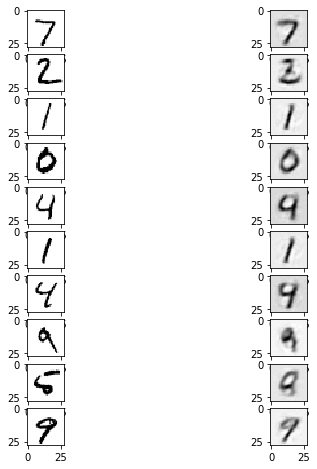

In [164]:
show_reconstruction(outputs,'./Autoencoder/Autoencoder_mnist.ckpt')

## Plot the hidden layer

In [120]:
def Plot_hidden_layer(layer_index=1,model_path=None):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess,model_path)
        weights = sess.run(tf.get_default_graph().get_tensor_by_name(os.path.split(x.name)[0] + 'dense/kernel:0'))   
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(weights.T[100+i].reshape(28,28), cmap="Greys", interpolation="nearest")
    
    

INFO:tensorflow:Restoring parameters from ./Autoencoder/Autoencoder_mnist.ckpt


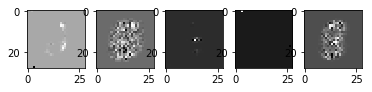

In [121]:
Plot_hidden_layer(1,'./Autoencoder/Autoencoder_mnist.ckpt')

## Faster training
Instead of training the while network in one go, it is much faster to train one autoencoder at a time and stack all of them together.
<img src='autoencoder.png'>

In [140]:
tf.reset_default_graph()

#### Build One autoencoder

In [141]:
def train_autoencoder(x_train,n_neurons,n_epochs,batch_size,learning_rate=0.01,l2_reg=tf.contrib.layers.l2_regularizer(0.0005),hidden_activation=tf.nn.elu,output_activation=tf.nn.elu,init = tf.initializers.variance_scaling()):
    graph = tf.Graph()
    with graph.as_default():
        n_inputs = x_train.shape[1]
        x = tf.placeholder(tf.float32,shape=[None,n_inputs])
        hidden = tf.layers.dense(x,n_neurons,activation=hidden_activation,kernel_initializer=init,kernel_regularizer=l2_reg,name='hidden')
        outputs= tf.layers.dense(hidden,n_inputs,activation=output_activation,kernel_initializer=init,kernel_regularizer=l2_reg,name='outputs')
        reconst_loss = tf.reduce_mean(tf.square(outputs-x))
        reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconst_loss]+reg_loss)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
        init = tf.global_variables_initializer() 
    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(x_train//batch_size)
            for iteration in range(n_batches):
                indices = rnd.permutation(len(x_train))[:batch_size]
                x_batch = x_train[indices]
                sess.run(training_op,feed_dict={x:x_batch})
            loss_train = reconst_loss.eval(feed_dict={x:x_train})
            print("\r{}".format(epoch), "Train MSE:", loss_train)    
        params = dict([(var.name,var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={x:x_train})
        return hidden_val,params['hidden/kernel:0'],params['hidden/bias:0'],params['outputs/kernel:0'],params['outputs/bias:0']             

In [165]:
 hidden_output,w1,b1,w4,b4 = train_autoencoder(mnist.train.images,n_neurons=300,n_epochs=1,batch_size=150,output_activation=None)
 _,w2,b2,w3,b3 = train_autoencoder(hidden_output,n_neurons=150,n_epochs=1,batch_size=150)  

0 Train MSE: 0.039022513
0 Train MSE: 0.040911812


#### Stack two autoencoder together by using weights and biases we just trained

In [143]:
tf.reset_default_graph()

In [144]:
n_inputs = 28*28
x = tf.placeholder(tf.float32,shape=[None,n_inputs])
hidden1 = tf.nn.elu(tf.matmul(x,w1)+b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1,w2)+b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2,w3)+b3)
outputs = tf.matmul(hidden3,w4)+b4

In [145]:
with tf.Session() as sess:
    output = outputs.eval(feed_dict={x:mnist.train.images})

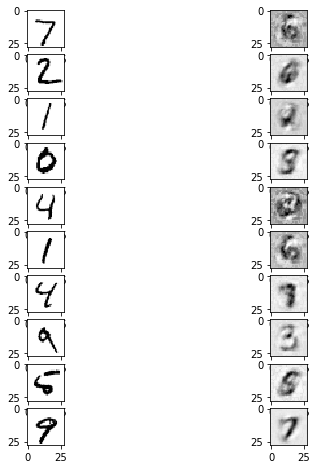

In [151]:
show_reconstruction(output)